Compute the normalised HSIC for weights of edges. This normalised statistic corresponds to distance correlation (https://arxiv.org/pdf/1606.07892.pdf): $\rho_{XY} = \frac{\|C_{XY}\|^2_{HS}}{\|C_{XX}\|_{HS}\|C_{YY}\|_{HS}}$

Moreover, in this notebook we precompute the kernel matrices for each continent and each goal.

# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to continents.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [2]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [3]:
# read amended csv file
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [4]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4) # removing Micronesia
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6) # removing Micronesia
continents['World'] = continents['World'].drop(index=170) # removing Micronesia
continents.drop(['Northern Africa', 'Southern Africa', 'North America', 'Australia and New Zealand'], axis=1, inplace=True)


In [5]:
continents

,Eastern Africa,Middle Africa,Western Africa,Sub-Saharan Africa,Africa,Caribbean,Central America,South America,Latin America and the Caribbean,Americas,...,Western Asia,Asia,Eastern Europe,Northern Europe,Southern Europe,Western Europe,Europe,Oceania (excl. AUS + NZ),Oceania (incl. AUS + NZ),World
0,Burundi,Angola,Benin,Burundi,Algeria,Antigua and Barbuda,Belize,Argentina,Antigua and Barbuda,Antigua and Barbuda,...,Armenia,Kazakhstan,Belarus,Denmark,Albania,Austria,Belarus,Fiji,Australia,Algeria
1,Comoros,Cameroon,Burkina Faso,Comoros,"Egypt, Arab Rep.","Bahamas, The",Costa Rica,Bolivia,"Bahamas, The","Bahamas, The",...,Azerbaijan,Kyrgyz Republic,Bulgaria,Estonia,Bosnia and Herzegovina,Belgium,Bulgaria,Papua New Guinea,New Zealand,"Egypt, Arab Rep."
2,Djibouti,Central African Republic,Cote d'Ivoire,Djibouti,Morocco,Barbados,El Salvador,Brazil,Barbados,Barbados,...,Bahrain,Tajikistan,Czech Republic,Finland,Croatia,France,Czech Republic,Solomon Islands,Fiji,Morocco
3,Eritrea,Chad,"Gambia, The",Eritrea,Tunisia,Cuba,Guatemala,Chile,Cuba,Cuba,...,Cyprus,Turkmenistan,Hungary,Iceland,Greece,Germany,Hungary,Vanuatu,Papua New Guinea,Tunisia
4,Ethiopia,"Congo, Rep.",Ghana,Ethiopia,Burundi,Dominica,Honduras,Colombia,Dominica,Dominica,...,Georgia,Uzbekistan,Poland,Ireland,Italy,Luxembourg,Poland,NaN,Solomon Islands,Burundi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palau
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kiribati
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Samoa
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tonga


We generate a list for all unique targets with their corresponding indicators. 

In [6]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [7]:
#check 
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [8]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [9]:
#check 
print(dict_goals['1'])

['1.1', '1.3', '1.2']


## Data preparation

Since we will work with groupings of countries according to continents, we prepare the data in the following way. We create a dictionary with continents as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

Moreover, we create a similar second dictionary, such that the entries of the 17-vector of each continent corresponds to the Kernel matrix of such SDG (considered here as a variable). This kernel matrices are computed using a Gaussian kernel with kernel bandwith computed using the median heuristic; and where the independent samples of a variable (SDG) $X^j$ correspond to the different countries of such continent.

In [19]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [20]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [41]:
# data preparation
continents_prep_g = {}
continents_prep_g_K = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(17, dtype=object)
    continents_prep_g_K[continent] = np.empty(17, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))
        
        g_array = np.asarray(g_list)
        continents_prep_g[continent][g] = g_array
        
        K_matrix = pairwise_kernels(g_array, metric='rbf', gamma=0.5/(width(g_array)**2))
        continents_prep_g_K[continent][g] = K_matrix

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [17]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [18]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [21]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [48]:
def dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat_found, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables. Using Monte Carlo approximation.
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha critical value
    Bind = np.sum(stat_found==statistics_sort) + int(np.ceil((1-alpha)*(n_perms+1)))
    critical_value = statistics_sort[Bind]
    
    return critical_value

In [57]:
def joint_independence_test_MC(k_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    k_list: list of Kernel matrices for each variable, each having dimensions (n_samples, n_samples)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    
    Returns:
    reject: 1 if null rejected, 0 if null not rejected
    
    """
    
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    
    # statistic and threshold
    stat = dHSIC(k_list)
    critical_value = dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat) 
    
    reject = int(stat > critical_value)
    
    return reject

## Pairwise HSIC implementation with normalisation

In [63]:
def HSIC_normalised_pairwise(group, groups_data, iterable):
    """
    Perform the independence test with HSIC for all possible pairwise combinations. If null hypothesis
    is rejected, compute the normalised HSIC statistic and set this as the weight of the edge between
    both variables (nodes of the graph).
    """
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to normalised HSIC
    Adj = np.eye(K)  #initialize KxK adjacency matrix 
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible 2-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, 2))   
    
    #compute individual HSIC_XX
    HSIC_XX_sqrt = []
    for i in indexes:
        k_list_XX = list((group_arr[i], group_arr[i]))
        HSIC_XX = dHSIC(k_list_XX)
        HSIC_XX_sqrt.append(np.sqrt(HSIC_XX))
    
    for comb in g_combinations: 
        #create k_list[i] = Kernel from observed data for variable comb[i]
        k_list = list((group_arr[comb[0]], group_arr[comb[1]]))
        
        HSIC_XY = dHSIC(k_list)
        critical_value = dHSIC_permutation_MC(k_list, k_list[0].shape[0], 2, HSIC_XY)
        
        if HSIC_XY > critical_value:
            HSIC_norm = HSIC_XY/(HSIC_XX_sqrt[comb[0]]*HSIC_XX_sqrt[comb[1]])
            Adj[comb[0], comb[1]] = HSIC_norm
            Adj[comb[1], comb[0]] = HSIC_norm
            
        
    return Adj

### Experiment on Goal level

In [88]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [89]:
n_labels = {}
for i in range(17):
    n_labels[i] = i+1

In [64]:
Adj_e = HSIC_normalised_pairwise('Europe', continents_prep_g_K, goals)

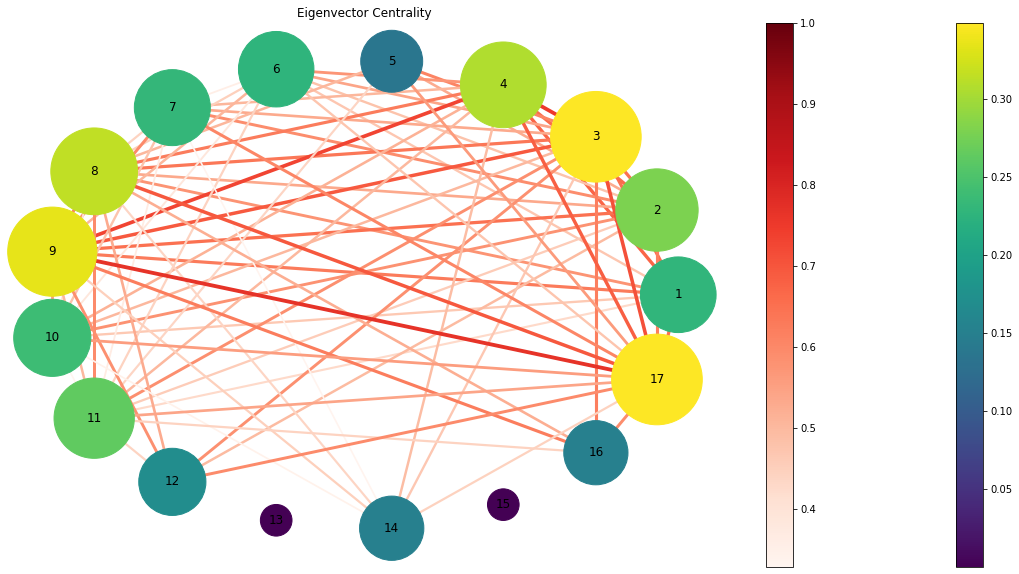

In [154]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_e)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [108]:
Adj_as = HSIC_normalised_pairwise('Asia', continents_prep_g_K, goals)

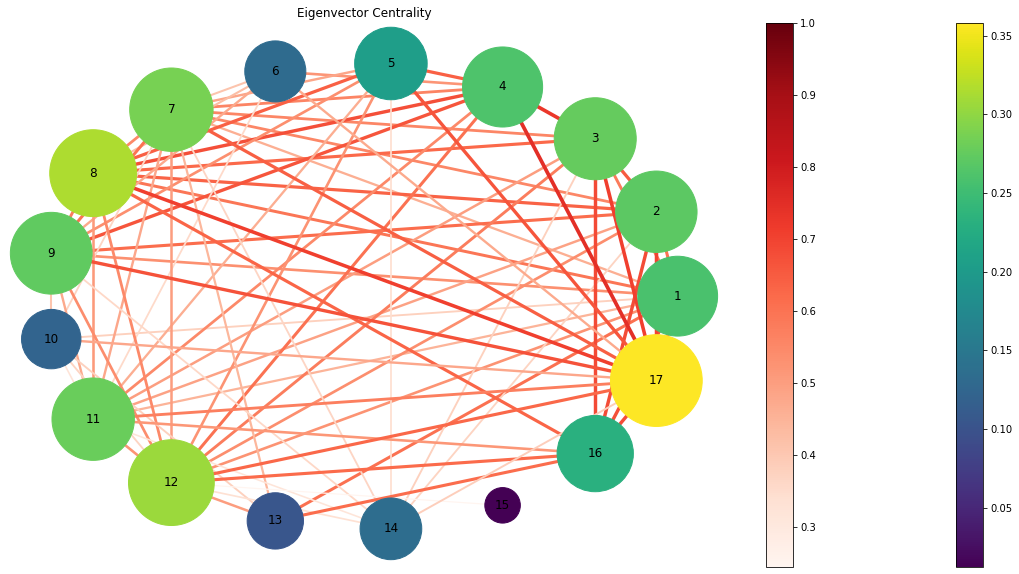

In [153]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_as)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [83]:
Adj_af = HSIC_normalised_pairwise('Africa', continents_prep_g_K, goals)

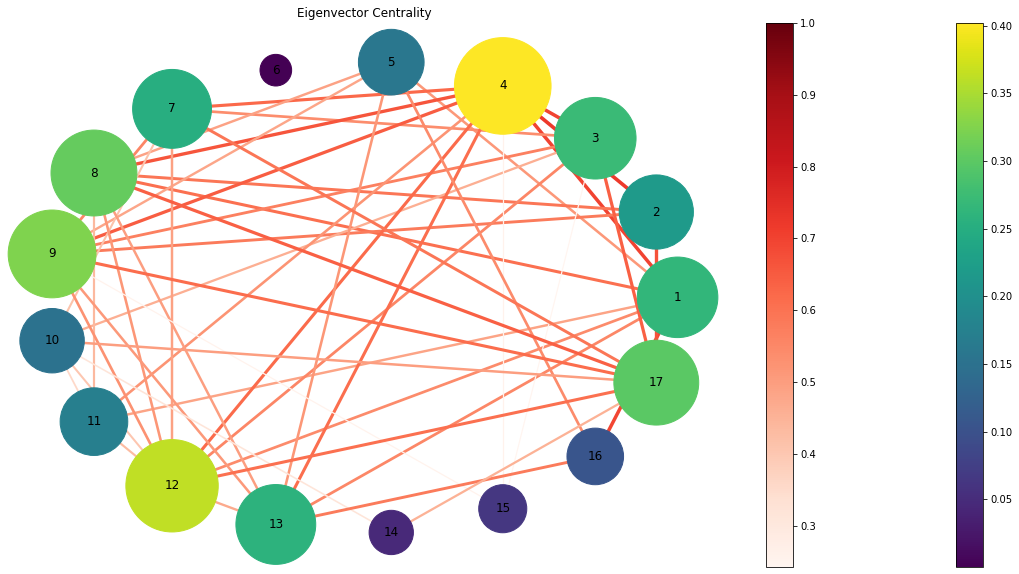

In [156]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_af)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G, weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"] for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

In [141]:
Adj_am = HSIC_normalised_pairwise('Americas', continents_prep_g_K, goals)

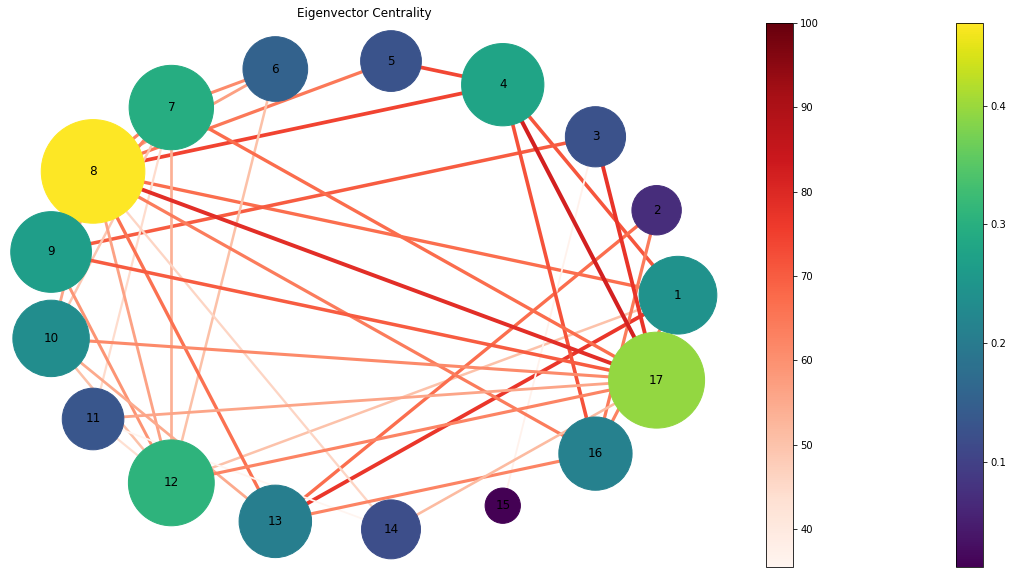

In [157]:
#graph with only 2-way dependencies
G = nx.Graph(Adj_am)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G,  weight='weight')     #compute degree centrality


for (u, v, d) in G.edges(data=True):
    G[u][v]["color"] = sns.color_palette('Reds', 100)[int(d["weight"]*100)-1]
    G[u][v]["alpha"] = d["weight"]
    G[u][v]["width"] = 10*d["weight"]


plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges


edges = nx.draw_networkx_edges(G, pos, edge_color=list(d["weight"]*100 for (u,v,d) in G.edges(data=True)), 
                       edge_cmap = plt.cm.Reds, 
                       width=list(d["weight"]*5 for (u,v,d) in G.edges(data=True)))
                       #edge_vmin=0.0,edge_vmax=1.0)
plt.colorbar(nodes)
plt.colorbar(edges)
plt.show(G)

## Algorithm for performing all possible independence tests with dHSIC

In [158]:
def dHSIC_links_MC(group, groups_data, iterable, stop_after_2=False, n_perms=5000, alpha=0.05):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create k_list[i] = Kernel from observed data for variable comb[i]
            k_list = []
            for i in range(d):
                k_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)
            reject = joint_independence_test_MC(k_list, n_perms, alpha)   
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination <d, then we should not consider the combinations involving 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

## Experiments on Goal level

Run the above algorithm for finding the high-order dependencies among SDGs in the lowest possible order, ie. starting from pariwise dependencies to d-dependencies.

We do this for the different continents in our dataset and save the results.

In [159]:
edges_e_MC, Adj2_e_MC = dHSIC_links_MC('Europe', continents_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  77
combinations:  3
number of combinations available:  99
Edges found with  3 nodes:  16
combinations:  4
number of combinations available:  61
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  22
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  3
Edges found with  6 nodes:  0


In [160]:
edges_af_MC, Adj2_af_MC = dHSIC_links_MC('Africa', continents_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  51
combinations:  3
number of combinations available:  171
Edges found with  3 nodes:  15
combinations:  4
number of combinations available:  106
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  22
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  1
Edges found with  6 nodes:  0


In [161]:
edges_as_MC, Adj2_as_MC = dHSIC_links_MC('Asia', continents_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  80
combinations:  3
number of combinations available:  77
Edges found with  3 nodes:  9
combinations:  4
number of combinations available:  33
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  3
Edges found with  5 nodes:  0


In [162]:
edges_am_MC, Adj2_am_MC = dHSIC_links_MC('Americas', continents_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  42
combinations:  3
number of combinations available:  241
Edges found with  3 nodes:  22
combinations:  4
number of combinations available:  241
Edges found with  4 nodes:  18
combinations:  5
number of combinations available:  92
Edges found with  5 nodes:  8
combinations:  6
number of combinations available:  7
Edges found with  6 nodes:  0


## Visualisation

In [163]:
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


### Europe

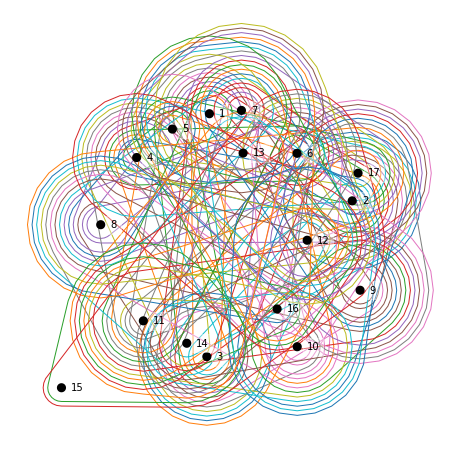

In [164]:
#hypergraph
He = hnx.Hypergraph(edges_e_MC)
hnx.draw(He, with_edge_labels=False)

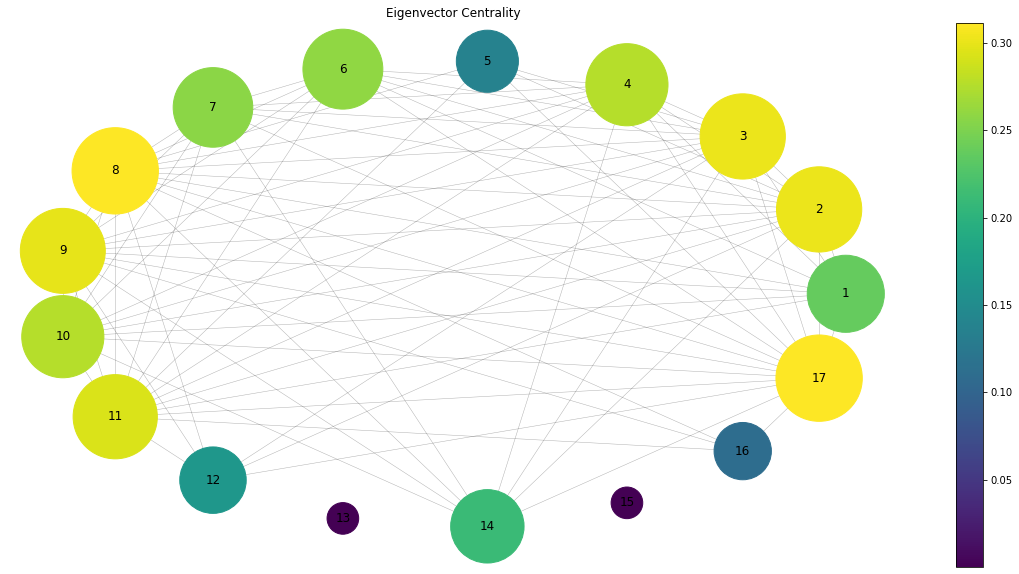

In [165]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_e_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [166]:
from hypernetx.algorithms.s_centrality_measures import *

In [167]:
centr_E = s_betweenness_centrality(He, s=1, normalized=True)

In [168]:
centr_E

{1: 0.007690602343477519,
 2: 0.007690602343477519,
 3: 0.007120502088945286,
 4: 0.006787967499748707,
 5: 0.008084923232188308,
 6: 0.007833081027330676,
 7: 0.007129786477612565,
 8: 0.008595564608888592,
 9: 0.008084923232188308,
 10: 0.0076248358155791545,
 11: 0.0071150292749170745,
 12: 0.005077843822584355,
 13: 0.0067279436318707,
 14: 0.008584247942592965,
 15: 0.008665041519178966,
 16: 0.008552338654021684,
 17: 0.007548309178743961,
 18: 0.009060753801286762,
 19: 0.007137106050149528,
 20: 0.006749092811505155,
 21: 0.008665041519178966,
 22: 0.0071150292749170745,
 23: 0.005077843822584355,
 24: 0.0067279436318707,
 25: 0.008584247942592965,
 26: 0.008665041519178966,
 27: 0.008552338654021684,
 28: 0.007548309178743961,
 29: 0.009060753801286762,
 30: 0.007137106050149528,
 31: 0.006749092811505155,
 32: 0.008665041519178966,
 33: 0.00583633874307086,
 34: 0.00818788634356657,
 35: 0.007679378436741691,
 36: 0.007485139918520001,
 37: 0.006565985440459493,
 38: 0.008022

### Asia

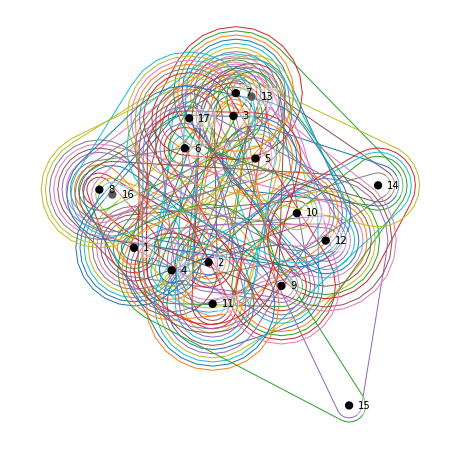

In [169]:
#hypergtraph
Has = hnx.Hypergraph(edges_as_MC)
hnx.draw(Has, with_edge_labels=False)

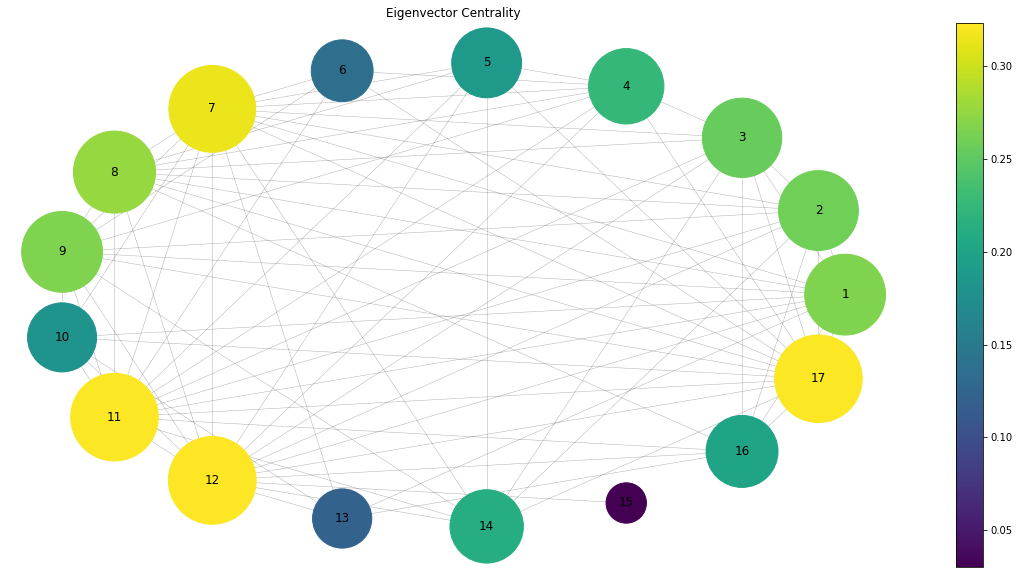

In [170]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_as_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Africa

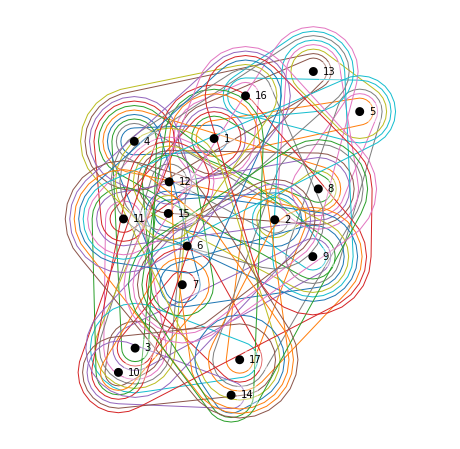

In [171]:
#hypergraph
Haf = hnx.Hypergraph(edges_af_MC)
hnx.draw(Haf, with_edge_labels=False)

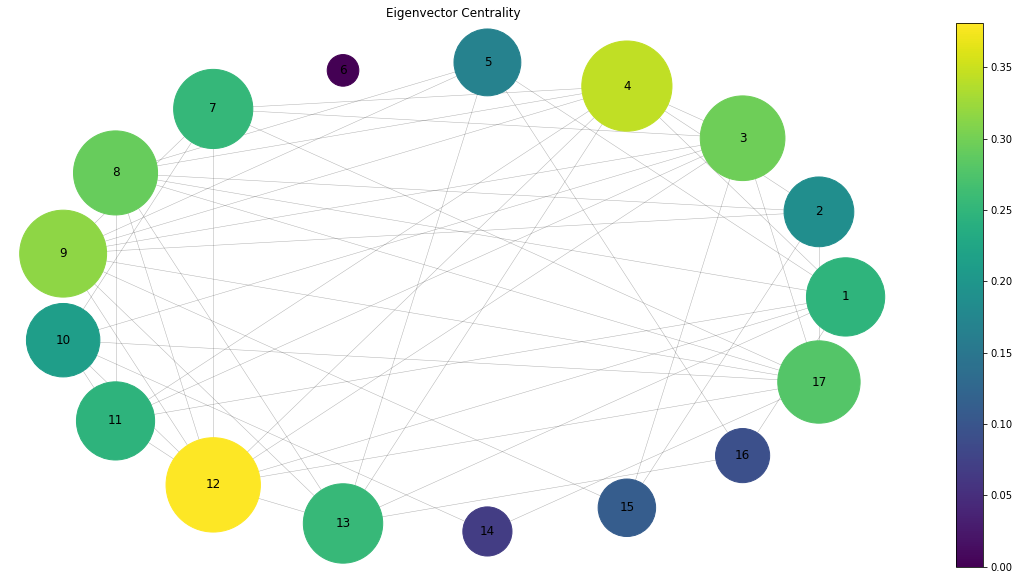

In [172]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_af_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Americas

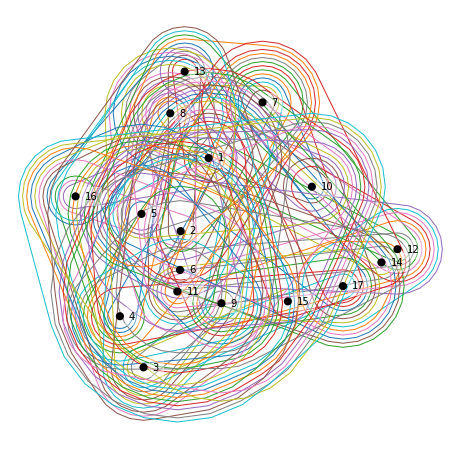

In [173]:
#hypergraph
Ham = hnx.Hypergraph(edges_am_MC)
hnx.draw(Ham, with_edge_labels=False)

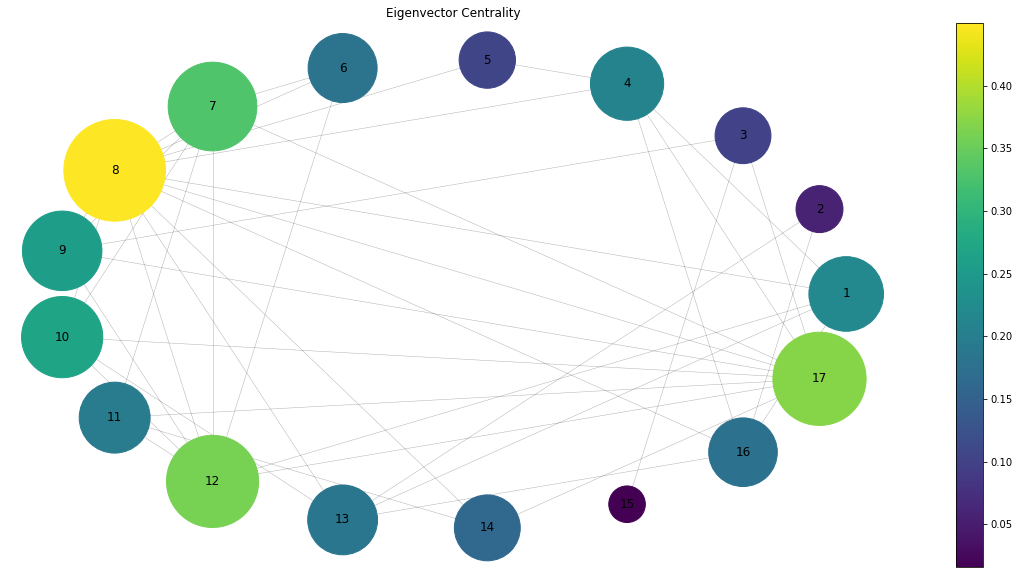

In [174]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_am_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis, 
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

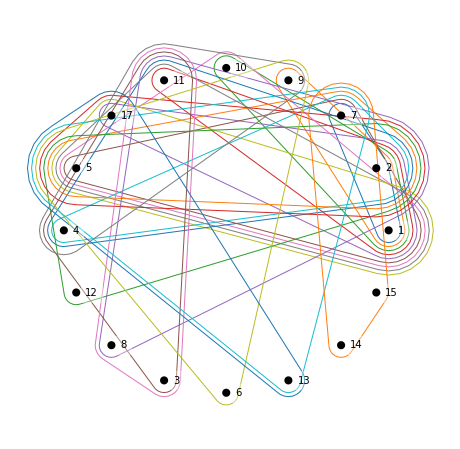

In [175]:
Ham_restrict_edges3 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==3))
hnx.draw(Ham_restrict_edges3, pos=nx.circular_layout(Ham_restrict_edges3), with_edge_labels=False)

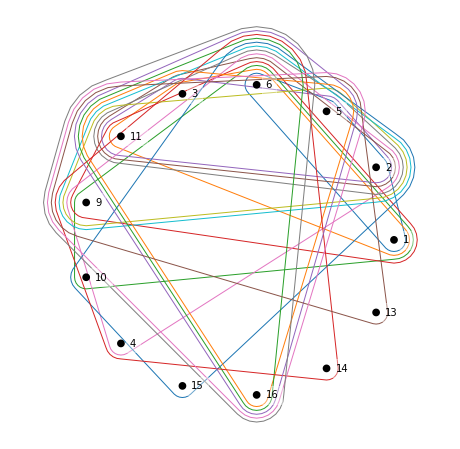

In [176]:
Ham_restrict_edges4 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==4))
hnx.draw(Ham_restrict_edges4, pos=nx.circular_layout(Ham_restrict_edges4),with_edge_labels=False)

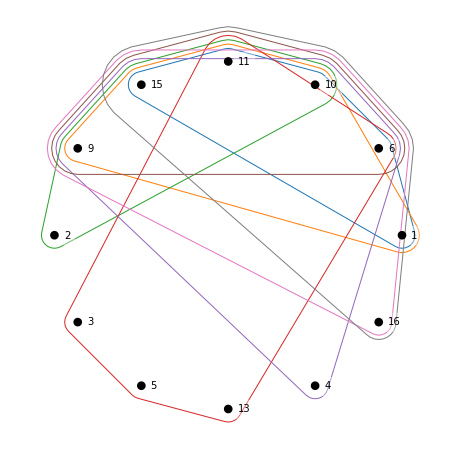

In [177]:
Ham_restrict_edges5 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==5))
hnx.draw(Ham_restrict_edges5, pos=nx.circular_layout(Ham_restrict_edges5), with_edge_labels=False)

## Trying different visualisations of hypergraphs

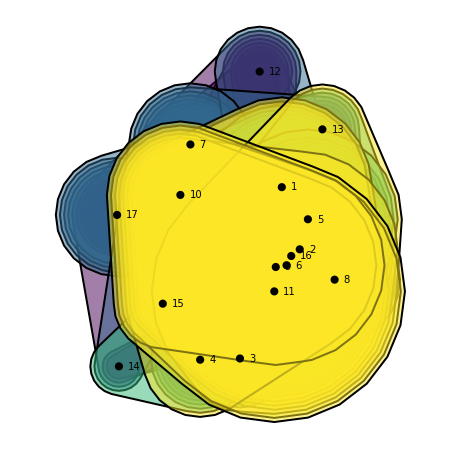

In [178]:
#Trying out different visualizations
cmap = plt.cm.viridis
alpha = .5

sizes = np.array([len(e) for e in Ham.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

hnx.drawing.draw(Ham,
                 label_alpha=0,
                 edges_kwargs={
                     'facecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
                     'edgecolors': 'black',
                     'linewidths': 2
                 }, with_edge_labels=False)

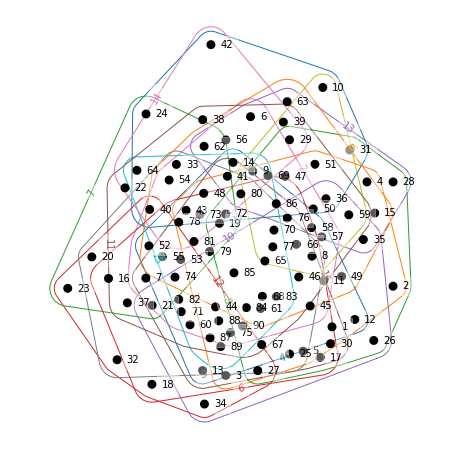

In [179]:
HD = Ham.dual()
hnx.draw(HD)

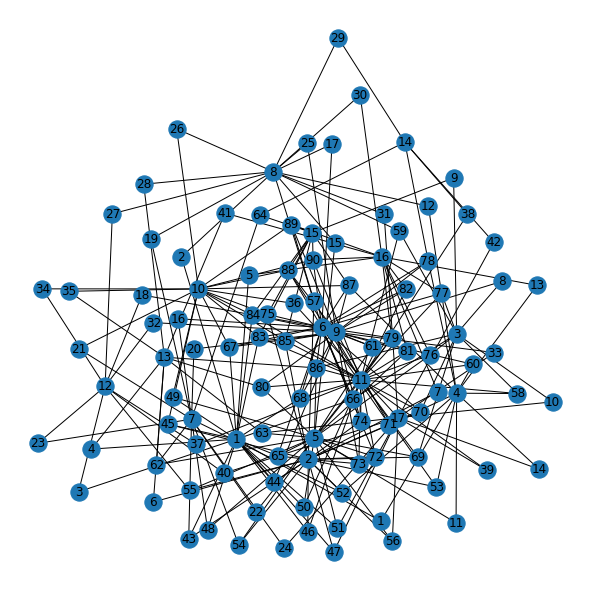

In [180]:
BH = Ham.bipartite()
nx.draw(BH, with_labels=True)

In [181]:
nodes_n = list(['{}'.format(i+1) for i in range(17)]) 
deg = nx.algorithms.bipartite.centrality.degree_centrality(BH, nodes=nodes_n) 

In [182]:
deg

{'12': 0.1,
 '10': 0.17777777777777778,
 '3': 0.12222222222222223,
 '8': 0.15555555555555556,
 '16': 0.13333333333333333,
 '9': 0.24444444444444446,
 '5': 0.23333333333333334,
 '2': 0.24444444444444446,
 '11': 0.33333333333333337,
 '14': 0.05555555555555556,
 '15': 0.11111111111111112,
 '17': 0.14444444444444446,
 '7': 0.14444444444444446,
 '13': 0.1,
 '4': 0.13333333333333333,
 '1': 0.22222222222222224,
 '6': 0.2555555555555556,
 1: 0.11764705882352941,
 2: 0.11764705882352941,
 3: 0.11764705882352941,
 4: 0.11764705882352941,
 5: 0.11764705882352941,
 6: 0.11764705882352941,
 7: 0.11764705882352941,
 8: 0.11764705882352941,
 9: 0.11764705882352941,
 10: 0.11764705882352941,
 11: 0.11764705882352941,
 12: 0.11764705882352941,
 13: 0.11764705882352941,
 14: 0.11764705882352941,
 15: 0.11764705882352941,
 16: 0.11764705882352941,
 17: 0.11764705882352941,
 18: 0.11764705882352941,
 19: 0.11764705882352941,
 20: 0.11764705882352941,
 21: 0.11764705882352941,
 22: 0.11764705882352941,
 23

In [183]:
M_ad = Ham.adjacency_matrix(s=1)
M_ad.toarray()

array([[ 0,  1,  1,  0,  0,  1,  1,  1,  1,  0,  1,  0,  0,  1,  0,  1,
         1],
       [ 1,  0,  1,  0,  2,  6,  1,  3,  1,  8,  5,  0,  1,  1,  1,  5,
         7],
       [ 1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  2,  1,  1,  1,  1,  1,
         1],
       [ 0,  0,  1,  0,  2,  1,  1,  2,  3,  1,  8,  0,  1,  0,  1,  1,
         4],
       [ 0,  2,  1,  2,  0,  3,  0,  1,  3,  2,  6,  0,  1,  0,  1,  1,
         5],
       [ 1,  6,  1,  1,  3,  0,  1,  5,  4,  5, 10,  1,  1,  1,  4,  4,
        10],
       [ 1,  1,  1,  1,  0,  1,  0,  2,  3,  0,  1,  1,  1,  1,  1,  2,
         0],
       [ 1,  3,  1,  2,  1,  5,  2,  0,  7,  2,  9,  0,  1,  3,  3,  6,
         6],
       [ 1,  1,  1,  3,  3,  4,  3,  7,  0,  0,  9,  0,  4,  3,  1,  5,
         5],
       [ 0,  8,  0,  1,  2,  5,  0,  2,  0,  0,  5,  1,  0,  1,  1,  2,
         6],
       [ 1,  5,  2,  8,  6, 10,  1,  9,  9,  5,  0,  1,  2,  1,  3,  6,
        12],
       [ 0,  0,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  

In [184]:
M_ad.toarray().shape

(17, 17)

In [185]:
Ham.degree('17', s=1)

13

In [186]:
Ham.degree('17', s=2)

13

In [187]:
Ham.degree('17', s=3)

4

In [188]:
Ham.degree('17', s=4)

0

In [189]:
Ham.degree('15', s=2)

10

In [190]:
Ham.degree('15', s=3)

9

In [191]:
Ham.degree('15', s=4)

8

In [192]:
degrees_2 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_2[node]= Ham.degree(node, s=2)
degrees_2

{'1': 20,
 '2': 22,
 '3': 11,
 '4': 12,
 '5': 21,
 '6': 23,
 '7': 13,
 '8': 14,
 '9': 22,
 '10': 16,
 '11': 30,
 '12': 9,
 '13': 9,
 '14': 5,
 '15': 10,
 '16': 12,
 '17': 13}

In [193]:
degrees_3 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_3[node]= Ham.degree(node, s=3)
degrees_3

{'1': 15,
 '2': 20,
 '3': 8,
 '4': 7,
 '5': 19,
 '6': 20,
 '7': 6,
 '8': 2,
 '9': 17,
 '10': 11,
 '11': 26,
 '12': 1,
 '13': 4,
 '14': 2,
 '15': 9,
 '16': 7,
 '17': 4}

In [194]:
# As with any iterator you can get all of the values in a list
list(Ham.neighbors('6'))

['12',
 '10',
 '3',
 '5',
 '2',
 '11',
 '14',
 '4',
 '1',
 '8',
 '16',
 '9',
 '15',
 '7',
 '13']

## Experiments on Target level

In [195]:
# data preparation
continents_prep_t = {}
continents_prep_t_K = {}

for continent in continents:
    print(continent)
    
    continents_prep_t[continent] = np.empty(76, dtype=object)
    continents_prep_t_K[continent] = np.empty(76, dtype=object)
    
    for t, target in enumerate(targets):
        t_list = []
        for country in continents[continent].dropna():
            t_list.append(np.asarray(targets_values_i[country][t]))
        
        t_array = np.asarray(t_list)
        continents_prep_t[continent][t] = t_array
        
        K_matrix = pairwise_kernels(t_array, metric='rbf', gamma=0.5/(width(t_array)**2))
        continents_prep_t_K[continent][t] = K_matrix

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [197]:
edges_e_t_MC, Adj2_e_t_MC = dHSIC_links_MC('Europe', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  1005


In [198]:
edges_af_t_MC, Adj2_af_t_MC = dHSIC_links_MC('Africa', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  451


In [ ]:
edges_as_t_MC, Adj2_as_t_MC = dHSIC_links_MC('Asia', continents_prep_t_K, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850


In [ ]:
edges_am_t_MC, Adj2_am_t_MC = dHSIC_links_MC('Americas', continents_prep_t_K, targets, stop_after_2=True)